# Question 1

# (a)
The probability of someone being negative, given that they have the marker P[-|M]=  1 - 0.95 = 0.05.
The probability that someone is positive, given that they do not have the parker P[+|not M] = 1 - 0.95 = 0.05
The probability that someone does not have the marker P[not M] = 1 - 0.01 = 0.99

# (b)
We need to find 
P[M | +] = P[+ | M] * P[M] / P[+]
         = 0.95 * 0.01 / (0.95 * 0.01 + 0.05 * 0.99)
         = 0.16

You should not be worried about having the genetic marker if you have kidney disease.  But the chance is not insignificant.  P[M] helps account for this result - the raw probability of the marker occurring in the population is already low.

# (c)
Redoing our math, 
0.95 * 0.1 / (0.95 * 0.1 + 0.05 * 0.9)
= 0.68

The marker is now highly prevalent in the population.  So it is likely that someone with kidney disease does have the genetic marker.


# Question 2

## (a)

We can represent the P(x | C) as a finite product of all the Gaussian probability densities P(x<sub>*i*</sub> | C)for each feature *i* (in this case, 13 features).   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Note: you can modify the template, define new attributes or functions as you want
class NaiveBayesClassifier():
    def __init__(self):
        # classes
        self.cls = []
        # statistics of features that belongs to different classes
        self.cls_stats = []
        # prior probablity, i.e. P(C)
        self.prior_prob = []

        self.trained = False
    
    @staticmethod
    def gaussian(X, mean, std):
        """
        Gaussain probability distribution function
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        mean: numpy.ndarray
            Average of each feature, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature, shape (n_features,)
            
        Returns
        -------
        prob: numpy.ndarray
            Probability of each feature, shape (n_samples, n_features)
        """
        g = np.exp(-0.5 * ((X - mean) / std)**2) / (std * np.sqrt(2 * np.pi))
        return g
    
    @staticmethod
    def calculate_statistics(X):
        """
        Calculate the average and standard deviation of each feature based on the input data
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
            
        Returns
        -------
        mean: numpy.ndarray
            Average of each feature, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature, shape (n_features,)
        """
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        return mean, std
    
    def calculate_prob(self, X, mean, std):
        """
        Calculate the prior probability that the input features belong to a specific class,
        i.e. P(X | C) = \prod_i P(X_i | C)
        which is defined by the statistics of features in that class.
        
        Gaussain probability distribution function
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        mean: numpy.ndarray
            Average of each feature in the speific class, shape (n_features,)
        std: numpy.ndarray
            Standard deviation of each feature in the specific class, shape (n_features,)
            
        Returns
        -------
        prob: numpy.ndarray
            Probability that the features belong to a spcefic class, shape (n_samples,)
        """
        likelihood = self.gaussian(X, mean, std)
        likelihood = np.prod(likelihood, axis=1)
        return likelihood
    
    def fit(self, X, y):
        """
        Train the classifier by calculating the statistics of different features in each class
        
        Parameters
        ----------
        X: numpy.ndarray
            Input data, shape (n_samples, n_features)
        y: numpy.ndarray
            Labels (the actual classes), shape (n_samples)
        """
        ndata = y.shape[0]
        self.cls = np.unique(y)
        self.prior_prob = []
        self.cls_stats = []
        for i in range(len(self.cls)):
            cls_filter = (y == self.cls[i])
            mean, std = self.calculate_statistics(X[cls_filter])
            self.prior_prob.append(np.sum(cls_filter) / ndata)
            self.cls_stats.append((mean, std))
        self.trained = True
            
    def predict(self, X):
        # Do the prediction by outputing the class that has highest probability
        assert self.trained, f"The classfier has not been trained. Call {self.__class__.__name__}.fit first"
        probs = []
        for i in range(len(self.cls)):
            likelihood = self.calculate_prob(X, self.cls_stats[i][0], self.cls_stats[i][1])
            posterior =  likelihood * self.prior_prob[i]
            #posterior /= np.sum(posterior, axis=0)
            probs.append(posterior)
        return self.cls[np.argmax(probs, axis=0)]

In [3]:
nbc = NaiveBayesClassifier()
wines = pd.read_csv('Datasets/wines.csv')
features = ['Alcohol %','Malic Acid','Ash','Alkalinity','Mg','Phenols','Flavanoids','Phenols','Proantho-cyanins','Color intensity','Hue','OD280 315','Proline']

X = wines.loc[:, 'Alcohol %']
y = wines.iloc[:, -1]
nbc.fit(X, y)
cls_filter = (y == 1)
# Given a wine that belongs to cultivar 1, what is the chance of it having an Alcohol % of 13 according to the probability distribution function?
mean, std = nbc.calculate_statistics(X[cls_filter])
res = nbc.calculate_prob([[13.0]], mean, std)
print("Chance that alcohol level is 13 percent, given a cultivar of 1:", res)

Chance that alcohol level is 13 percent, given a cultivar of 1: [0.23236758]


In [4]:
ndata = y.shape[0]
train_size = round(ndata * 2/3)
test_size = ndata - train_size
X_train = X[train_size]
y_train = y[train_size]

X_test = X[test_size]
y_test = y[test_size]

nbc2 = NaiveBayesClassifier()


## (b)

Preprocess data:
+ Select relevant descriptors (columns other than "Start assignment" and "ranking"). Should get *178 datapoints and 13 features*.
+ Normalize the data with `StandardScaler` in sklearn.
+ The labels are in the "ranking" column.

*For debugging*: The accuracy could reach over 95\%.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [6]:
def calculate_accuracy(model, X, y):

    y_pred = model.predict(X)

    acc = np.sum(y_pred == y) / len(y)
    return acc
    
def KFoldNaiveBayes(k, X, y):
    """
    K-Fold Cross Validation for Naive Bayes Classifier
    
    Parameters
    ---------
    k: int
        Number of folds
    X: numpy.ndarray
        Input data, shape (n_samples, n_features)
    y: numpy.ndarray
        Class labels, shape (n_samples)
    """
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_all = []
    test_acc_all = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = NaiveBayesClassifier()
        model.fit(X_train, y_train)
        # Report prediction accuracy for this fold
        # use the calculate_accuracy() function
        train_acc = calculate_accuracy(model, X_train, y_train)
        train_acc_all.append(train_acc)
        test_acc = calculate_accuracy(model, X_test, y_test)
        test_acc_all.append(test_acc)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
    
    # report mean & std for the training/testing accuracy
    print("Final results:")
    print("Training accuracy:", np.mean(train_acc_all))
    print("Training std:", np.std(train_acc_all))
    print("Testing  accuracy:", np.mean(test_acc_all))
    print("Testing std:", np.std(test_acc_all))

In [7]:
wines = pd.read_csv('Datasets/wines.csv')
X = wines[features]
print(np.shape(X))
normalized_X = pd.DataFrame(StandardScaler().fit_transform(X))
#normalized_X = normalized_X.sample(frac=1).reset_index(drop=True)
KFoldNaiveBayes(3, normalized_X, y)

(178, 13)
Train accuracy: 0.9745762711864406
Test accuracy: 0.9833333333333333
Train accuracy: 0.9747899159663865
Test accuracy: 0.9830508474576272
Train accuracy: 0.9831932773109243
Test accuracy: 0.9491525423728814
Final results:
Training accuracy: 0.9775198214879172
Training std: 0.004012687109216623
Testing  accuracy: 0.9718455743879474
Testing std: 0.016046811232455657


# Question 3

## (a)

In [8]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [9]:
# Define your model here
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, doSoftmax=True):
        super().__init__()
        layers = [nn.Linear(input_size, output_size)]
        if doSoftmax:
            layers.append(nn.Softmax(dim=1))
        self.layers = nn.Sequential(*layers)
    def forward(self, X):
        o = self.layers(X)
        return o

In [10]:
wines = pd.read_csv("Datasets/wines.csv")
X = torch.tensor(normalized_X.values, dtype=torch.float32)
y = torch.tensor(wines.iloc[:, -1].values-1)
model = NeuralNetwork(X.shape[1], len(torch.unique(y)))
model2 = NeuralNetwork(X.shape[1], len(torch.unique(y)), doSoftmax=False)
res = model(X)
print("With softmax:\n", res)
res2 = model2(X)
print("without softmax:\n", res2)


With softmax:
 tensor([[0.0815, 0.3422, 0.5763],
        [0.3964, 0.2073, 0.3963],
        [0.1077, 0.1989, 0.6934],
        [0.1377, 0.3219, 0.5404],
        [0.1551, 0.2875, 0.5575],
        [0.1566, 0.1840, 0.6594],
        [0.1013, 0.2672, 0.6316],
        [0.2219, 0.4127, 0.3655],
        [0.2260, 0.3443, 0.4297],
        [0.1382, 0.3876, 0.4742],
        [0.1061, 0.3659, 0.5281],
        [0.1702, 0.2036, 0.6262],
        [0.4424, 0.2044, 0.3532],
        [0.2968, 0.2727, 0.4305],
        [0.1876, 0.2303, 0.5820],
        [0.1165, 0.3437, 0.5398],
        [0.1343, 0.2257, 0.6400],
        [0.1390, 0.3265, 0.5345],
        [0.1131, 0.1410, 0.7460],
        [0.1255, 0.1720, 0.7025],
        [0.5404, 0.2123, 0.2474],
        [0.2614, 0.1547, 0.5839],
        [0.1108, 0.2661, 0.6231],
        [0.2740, 0.5310, 0.1950],
        [0.4037, 0.4409, 0.1554],
        [0.4216, 0.3036, 0.2748],
        [0.3662, 0.4111, 0.2227],
        [0.2905, 0.3627, 0.3468],
        [0.4199, 0.3905, 0.1896],

# (a)

Softmax is a function that calculates multiple class probability.  It is similar to sigmoid, but the problem with sigmoid (and in this case, linear regression), is that you only receive scalars as a raw probability of being in class 0 or class 1.  You can't use raw output with multiple classes - we see that we have unnormalized confidence scores when we do not use Softmax (this doesn't make sense).  Thus, softmax helps normalize the probabilities for each sample such that they add to 1.  Therefore, we can see the probability of each sample of being in class 0, 1, or 2.

## (b)

*For debugging*: The accuracy could reach over 95\% if the hyperparamters are tuned properly.

## I changed the number of epochs from 500 -> 1250 to achieve ~95% accuracy most of the time.



In [11]:
def train_and_val(model, X_train, y_train, epochs, draw_curve=True):
    """
    Further split the data into acutal train and validation subsets.
    """
    # Define your loss function, optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    X_train_in, X_val, y_train_in, y_val = train_test_split(X_train, y_train, test_size=0.2)
    
    val_losses = []
    lowest_val_loss = np.inf
    
    weights = {}
    for i in range(epochs):
        # Compute the loss and do back-propagation
        y_train_pred = model(X_train_in)
        loss = loss_func(y_train_pred, y_train_in)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute validation loss and keep track of the lowest val loss
        with torch.no_grad():
            val_loss = loss_func(model(X_val), y_val)
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            weights = model.state_dict() 
        val_losses.append(val_loss)
        
    # The final number of epochs is when the minimum error in validation set occurs    
    final_epochs = np.argmin(val_losses)
    print("Number of epochs with lowest validation:", final_epochs)
    print(f"Validation loss: {np.min(val_losses)}")
    # Recover the model weights
    model.load_state_dict(weights)

    if draw_curve:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
        ax.plot(np.arange(epochs), val_losses, label='Validation loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
    
    return model


def calculate_accuracy_nn(model, X, y):
    with torch.no_grad():
        y_pred = torch.argmax(model(X), axis=1)
        acc = torch.sum(y_pred == y) / len(y)
    return acc.detach().numpy()


def KFoldNN(k, X, y, epochs=500):
    """
    K-Fold Validation for Neural Network
    
    Parameters
    ---------
    k: int
        Number of folds
    X: numpy.ndarray
        Input data, shape (n_samples, n_features)
    y: numpy.ndarray
        Class labels, shape (n_samples)
    epochs: int
        Number of epochs during training
    """
    # K-Fold
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_all = []
    test_acc_all = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # further do a train/valid split on X_train
        model = NeuralNetwork(X_train.shape[1], len(torch.unique(y)))
        model = train_and_val(model, X_train, y_train, epochs)
        # Report prediction accuracy for this fold
        # use calculate_accuracy_nn() function
        train_acc = calculate_accuracy_nn(model, X_train, y_train)
        train_acc_all.append(train_acc)
        test_acc = calculate_accuracy_nn(model, X_test, y_test)
        test_acc_all.append(test_acc)
        print("Train accuracy:", train_acc)
        print("Test accuracy:", test_acc)
    
    # report mean & std for the training/testing accuracy
    print("Final results:")
    print("Training accuracy:", np.mean(train_acc_all))
    print("Training std:", np.std(train_acc_all))
    print("Testing  accuracy:", np.mean(test_acc_all))
    print("Testing std:", np.std(test_acc_all))

Number of epochs with lowest validation: 1249
Validation loss: 0.5666986107826233
Train accuracy: 1.0
Test accuracy: 0.98333335
Number of epochs with lowest validation: 1249
Validation loss: 0.6230376362800598
Train accuracy: 0.99159664
Test accuracy: 0.9322034
Number of epochs with lowest validation: 1249
Validation loss: 0.6113277077674866
Train accuracy: 0.9831933
Test accuracy: 0.9661017
Final results:
Training accuracy: 0.9915967
Training std: 0.006861315
Testing  accuracy: 0.9605462
Testing std: 0.021240147


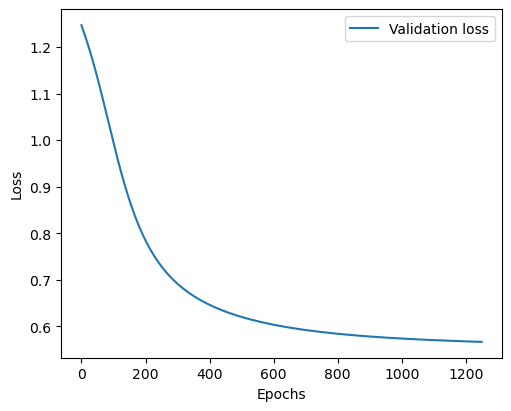

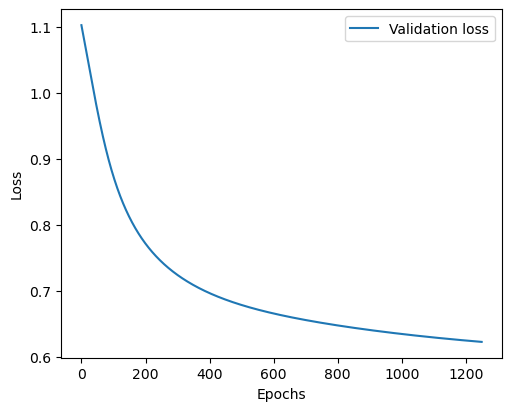

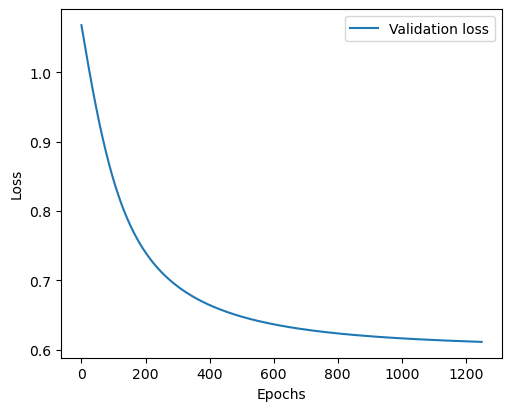

In [12]:
KFoldNN(3, X, y, epochs=1250)

# (b)
The prediction is almost equivalent to the Gaussian Naive Bayes.  I am using the test data ("unseen" data) as the metric of comparison here.  I suppose that the data is relatively linear, meaning that having a linear activation function in the first layer of the NN is the same as generating a Gaussian PDF.  The data is also quite low-dimensional, meaning that a Gaussian NB will still perform as well as an NN.